# GEE Export
Calculate the MCI from sentinel-3 data and save it in a local folder together with the quality masks (and other sentinel-3 layers if needed).

### Parameters

In [423]:
daterange = ("2018-06-01", "2018-07-01")
name_export = "MCI_sentinel3"
savepath = "exports"

In [ ]:
# general imports
import math
import sys
import os
from osgeo import gdal
import numpy as np
import glob
import matplotlib.pyplot as plt

# GEE imports
import ee
# from ee import batch
from geetools import batch
ee.Initialize()

# import polygons
from gee_polygons import ijssel_rect, ijssel_precise, ijssel_poly

def getQABits(image, start, end, mascara):
    # Compute the bits we need to extract.
    pattern = 0
    for i in range(start,end+1):
        pattern += 2**i
        
    # Return a single band image of the extracted QA bits, giving the     band a new name.
    return image.select([0], [mascara]).bitwiseAnd(pattern).rightShift(start)

# A function to mask out cloudy pixels.
def maskQuality(image):
    
    # Select the QA band.
    QA = image.select('quality_flags')
    
    # Get the internal_cloud_algorithm_flag bit.
    bright = getQABits(QA,27,27,'Bright') #4?
    invalid = getQABits(QA,25,25,'Invalid')
    
    #  var cloud_confidence = getQABits(QA,6,7,  'cloud_confidence')
    cosmetic = getQABits(QA,24,24,'Cosmetic')
    #var cirrus_detected2 = getQABits(QA,8,8,  'cirrus_detected2')
    
    # Return an image masking out cloudy areas.
    return image.updateMask(bright.eq(0)).updateMask(invalid.eq(0).updateMask(cosmetic.eq(0)))

# based on https://gis.stackexchange.com/questions/274048/apply-cloud-mask-to-landsat-imagery-in-google-earth-engine-python-api
def ExportCol(col, folder, scale, typei, nimg, maxPixels, region, name_export):
    os.makedirs(os.path.join(folder,name_export), exist_ok=True)
    # I'm not quite sure but I think this just makes a list large enough that all images will fit
    # so toList(500) gives a 500 element long list, but the col part uses maybe only 37 of those 500
    # so the final list is then 37 elements.
    colList = col.toList(nimg)
    n = colList.size().getInfo()
    print("Processing {} images".format(n))
    for i in range(0,n):
        
        img_tmp = ee.Image(colList.get(i))
        img = get_MCI_clipped(img_tmp)
        
        # hack to get give the band the right name
        img = img.select([0], ['MCI'])
        
        id_img = img_tmp.id().getInfo()
        # img.set(id_img, "system:index")
        
        # date formatted according to http://joda-time.sourceforge.net/apidocs/org/joda/time/format/DateTimeFormat.html
        datestr = ee.Date(img_tmp.get('system:time_start')).format('YYYY-MM-dd').getInfo()
        print('image date: {}'.format(datestr))
        print("original img id: {}".format(id_img))

        imgtype = {"float":img.toFloat(), 
                    "byte":img.toByte(), 
                    "int":img.toInt(),
                    "double":img.toDouble()
                  }
        task_config = {
            'image': imgtype[typei],
            'description': id_img,
            'scale': scale,  
            'region': region,
            'folder': folder,
            'maxPixels': maxPixels,
            'fileNamePrefix': id_img
            }
        
        
        # toLocal(image, name=None, path=None, scale=None, region=None, dimensions=None, toFolder=True)
        # export MCI
        batch.Download.image.toLocal(img, name=datestr, scale=scale, region=region, path=os.path.join(folder,name_export), toFolder=True)
        
        # export quality flags to get the bits in an usable format you will have to extract the bits and expand them to seperate layers,
        # in this format they are saved as a bitstring for each pixel
        batch.Download.image.toLocal(img_tmp.select(['quality_flags']), name=datestr, scale=scale, region=region, path=os.path.join(folder,name_export), toFolder=True)
        
        # export RGB with multiplication
        rgb = img_tmp.select(['Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance'], ['Red','Green','Blue']).multiply(ee.Image([0.00876539, 0.0123538, 0.0115198]))
        batch.Download.image.toLocal(rgb, name=datestr, scale=scale, region=region, path=os.path.join(folder,name_export), toFolder=True)
        
        # export all layers
#         batch.Download.image.toLocal(img_tmp, name=datestr, scale=scale, region=region, path=os.path.join(folder,name_export), toFolder=True)
    
    
def get_MCI_clipped(img):
    """convert ee.Image to MCI ee.Image"""
    img = img.clip(ijssel_rect);
  
    # calculate MCI
    # bands can be found here: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S3_OLCI
    MCI = img.expression(
        'l709 - l681 - (((709-681)/(753-681)) * (l753-l681))', {
        'l709': img.select('Oa11_radiance'),
        'l681': img.select('Oa10_radiance'),
        'l753': img.select('Oa12_radiance')
    })
    MCI = MCI.copyProperties(img)
    MCI = ee.Image(MCI)
    return MCI

daterangestr = "{}_{}".format(daterange[0], daterange[1])

# sentinel3 data
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S3_OLCI
dataset = ee.ImageCollection('COPERNICUS/S3/OLCI').filterBounds(ijssel_rect).filterDate(daterange[0], daterange[1])

# ExportCol = function(col, folder, scale, type, nimg, maxPixels, region)
ExportCol(dataset,savepath,300,"float",300,1e12, ijssel_rect, name_export)

## Data Inspection 
Functions for inspecting the exported data.

In [413]:
def read_gee_files(path):
    all_tifs = glob.glob(path + "/*.tif")
    mci_path = [fname for fname in all_tifs if "MCI" in fname][0]
    red_path = [fname for fname in all_tifs if "Red" in fname][0]
    blue_path = [fname for fname in all_tifs if "Blue" in fname][0]
    green_path = [fname for fname in all_tifs if "Green" in fname][0]
    qb_path = [fname for fname in all_tifs if "quality_flags" in fname][0]
    
    print(mci_path)
    
    mci_gtif = gdal.Open(mci_path)
    red_gtif = gdal.Open(red_path)
    blue_gtif = gdal.Open(blue_path)
    green_gtif = gdal.Open(green_path)
    qb_gtif = gdal.Open(qb_path)
    mci = mci_gtif.ReadAsArray()
    red = red_gtif.ReadAsArray()
    blue = blue_gtif.ReadAsArray()
    green = green_gtif.ReadAsArray()
    qb_bits = qb_gtif.ReadAsArray()
    qb_masks = transform_qb_mask(qb_bits)
    
    rgb = np.stack([red,green,blue], axis=2)
    
    return mci, rgb, qb_masks

def transform_qb_mask(image):
    get_bitvector = np.vectorize(lambda x: "{0:b}".format(int(x)))
    expand_bitvector = np.vectorize(lambda s: np.fromstring(s,'u1') - ord('0'))

    flatty = image.flatten()
    result = get_bitvector(flatty)
    result = result.reshape(image.shape)

    expanded_mask = np.zeros((image.shape[0], image.shape[1], 32), dtype=np.uint8)
    error_count = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            bit_array = expand_bitvector(result[i,j])
            if len(bit_array) < 32:
                tmp = np.zeros(32, dtype=np.uint8)
                tmp[-len(bit_array):] = bit_array
                bit_array = tmp
            if len(bit_array) < 32:
                error_count+=1

            expanded_mask[i,j,:len(bit_array)] = bit_array

    print('error count: {}'.format(error_count))
    return expanded_mask

mci, rgb, qb_masks = read_gee_files("exports/MCI_sentinel3/2018-06-05")
print(mci.shape)
print(rgb.shape)
print(qb_masks.shape)

exports/MCI_sentinel3/2018-06-05/2209ab25327ffcb965a94ffc72f92b20.MCI.tif


/data/anaconda3/envs/gee/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


error count: 0
(296, 181)
(296, 181, 3)
(296, 181, 32)


min of image: -5.0, max: 5.0


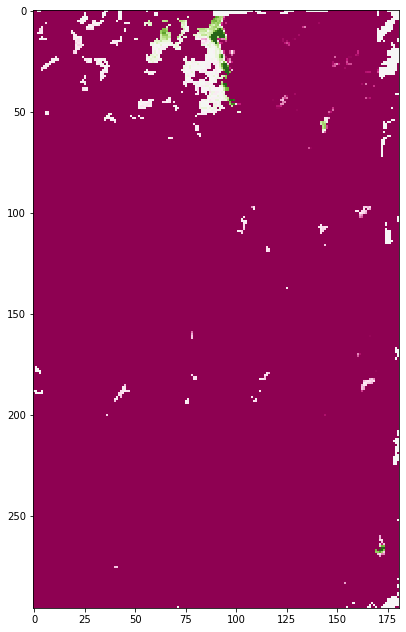

In [421]:
image = rgb / 6 #6 is the max value in the rgb image, see GEE sentinel3 documentation
# image = mci

# good color range for mci (most of the time)
# image[image<-5] = -5
# image[image>5] = 5

# masking
bit = 4 # cloudmask
image[qb_masks[:,:,bit] == 1] = -5 # set masked areas to lowest value 

f, axs = plt.subplots(figsize=(20,11))
print("min of image: {}, max: {}".format(np.min(image), np.max(image)))
# diverging colormap is useful for plotting MCI
plt.imshow(image, cmap='PiYG')
plt.show()
# import seaborn as sns
# sns.distplot(mci.flatten())